In [2]:
import pandas as pd
import numpy as np
import shap
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
import xgboost as xgb
import os


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [11]:

# Ruta donde están todos los CSVs
folder_path = "Tests_limpio/player_stats_con_resultado"

# Listar todos los archivos CSV en la carpeta
csv_files = [f for f in os.listdir(folder_path) if f.endswith(".csv")]

# Función para procesar un solo archivo CSV
def procesar_csv(file_path):
    df = pd.read_csv(file_path)

    # Eliminar columnas no numéricas o irrelevantes
    columns_to_drop = ['Date', 'Tournament', 'Rd', 'Rk', 'vRk', 'match', 'Score', 'Time', 'Player', 'Opponent', 'Surface','TPW', 'DR']
    df = df.drop(columns=columns_to_drop, errors='ignore')

    # Convertir la variable objetivo W_or_L a binaria
    df["W_or_L"] = df["W_or_L"].map({"W": 1, "L": 0})

    # Convertir fracciones tipo '3/5' a porcentaje
    def convert_fraction_to_percentage(value):
        try:
            if isinstance(value, str) and '/' in value:
                num, denom = value.split('/')
                return (float(num) / float(denom)) * 100 if float(denom) != 0 else 0.0
            else:
                return float(value)
        except:
            return None

    # Convertir porcentajes y fracciones a escala 0–100
    for col in df.columns:
        if df[col].dtype == "object":
            if df[col].str.endswith('%').any():
                df[col] = df[col].str.replace('%', '', regex=False).astype(float)
            elif df[col].str.contains(r'\d+/\d+').any():
                df[col] = df[col].apply(convert_fraction_to_percentage)

    # Eliminar filas con valores faltantes
    df = df.dropna()

    # Separar X e y
    X = df.drop(columns=["W_or_L"])
    y = df["W_or_L"]

    print(f"\nArchivo: {os.path.basename(file_path)}")
    print("Variables seleccionadas:", list(X.columns))
    print("Tamaño final:", X.shape)

    return df, X, y

# Aplicar a todos los archivos
for csv_name in csv_files:
    csv_path = os.path.join(folder_path, csv_name)
    df, X, y = procesar_csv(csv_path)
    # Aquí puedes añadir tu modelo, análisis SHAP, etc.



Archivo: AlexanderZverev_matches_full_con_WorL.csv
Variables seleccionadas: ['A%', 'DF%', '1stIn', '1st%', '2nd%', 'BPSvd', 'RPW', 'vA%', 'v1st%', 'v2nd%', 'BPCnv', 'TP', 'Aces', 'DFs', 'SP', '1SP', '2SP', 'vA']
Tamaño final: (734, 18)

Archivo: AndreyRublev_matches_full_con_WorL.csv
Variables seleccionadas: ['A%', 'DF%', '1stIn', '1st%', '2nd%', 'BPSvd', 'RPW', 'vA%', 'v1st%', 'v2nd%', 'BPCnv', 'TP', 'Aces', 'DFs', 'SP', '1SP', '2SP', 'vA']
Tamaño final: (666, 18)

Archivo: CarlosAlcaraz_matches_full_con_WorL.csv
Variables seleccionadas: ['A%', 'DF%', '1stIn', '1st%', '2nd%', 'BPSvd', 'RPW', 'vA%', 'v1st%', 'v2nd%', 'BPCnv', 'TP', 'Aces', 'DFs', 'SP', '1SP', '2SP', 'vA']
Tamaño final: (343, 18)

Archivo: CasperRuud_matches_full_con_WorL.csv
Variables seleccionadas: ['A%', 'DF%', '1stIn', '1st%', '2nd%', 'BPSvd', 'RPW', 'vA%', 'v1st%', 'v2nd%', 'BPCnv', 'TP', 'Aces', 'DFs', 'SP', '1SP', '2SP', 'vA']
Tamaño final: (543, 18)

Archivo: DaniilMedvedev_matches_full_con_WorL.csv
Variables s

In [12]:
# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo
dt_model = DecisionTreeClassifier(max_depth=5, random_state=42)
dt_model.fit(X_train, y_train)

# Evaluación
y_pred = dt_model.predict(X_test)
report = classification_report(y_test, y_pred, output_dict=True)
report_df = pd.DataFrame(report).transpose()

# Importancia de variables
importances = pd.Series(dt_model.feature_importances_, index=X.columns).sort_values(ascending=False)

# Mostrar resultados
print("=== Informe de Evaluación ===")
print(report_df)

print("\n=== Importancia de Variables ===")
print(importances)

=== Informe de Evaluación ===
              precision    recall  f1-score     support
0              0.843137  0.843137  0.843137   51.000000
1              0.887324  0.887324  0.887324   71.000000
accuracy       0.868852  0.868852  0.868852    0.868852
macro avg      0.865231  0.865231  0.865231  122.000000
weighted avg   0.868852  0.868852  0.868852  122.000000

=== Importancia de Variables ===
RPW      0.435528
1st%     0.190461
2nd%     0.096671
BPSvd    0.092128
BPCnv    0.068528
v1st%    0.038878
SP       0.022003
1stIn    0.018396
TP       0.015591
vA%      0.013083
DFs      0.008731
A%       0.000000
DF%      0.000000
v2nd%    0.000000
Aces     0.000000
1SP      0.000000
2SP      0.000000
vA       0.000000
dtype: float64


A%       0.000000           
DF%      0.000000   ---
v2nd%    0.000000
Aces     0.000000   X
1SP      0.000000   X
2SP      0.000000   X
vA       0.000000   ---

vA%      0.024442   o quito esta o la otra(vA)
A%       0.022955
TP       0.022947
1SP      0.022268   X
SP       0.020300
1stIn    0.019843
Aces     0.018028   X
2SP      0.015872   X
DFs      0.015598   --- HAY QUE QUITAR 1 DE DF PERO NO LOS DOS PQ ES IMPORTANTE PARA EL INFORME SABER SI EL JUGADOR SUELE COMETER MUCHAS DF

vA%      0.024442   o quito esta o la otra(vA)
A%       0.022955
TP       0.022947
1SP      0.022268   X
SP       0.020300
1stIn    0.019843
Aces     0.018028   X
2SP      0.015872   X
DFs      0.015598   ---

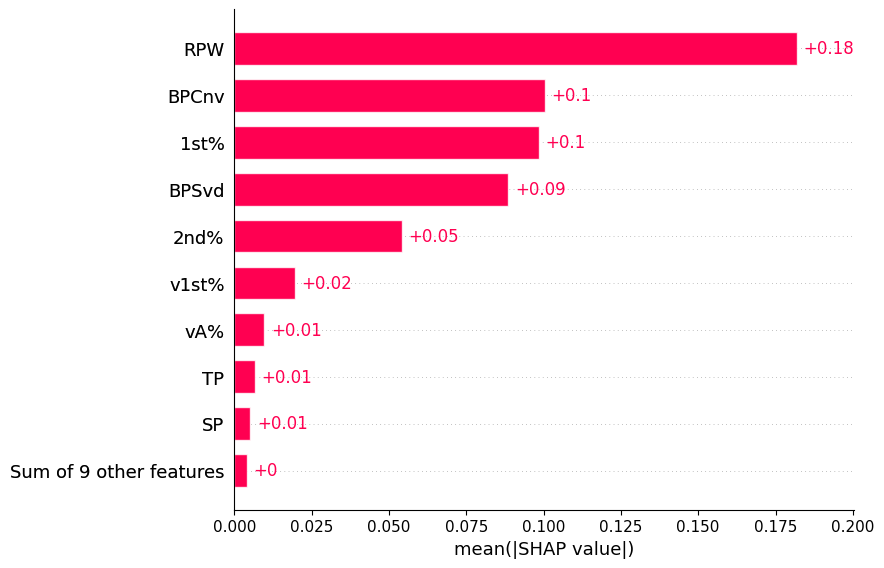

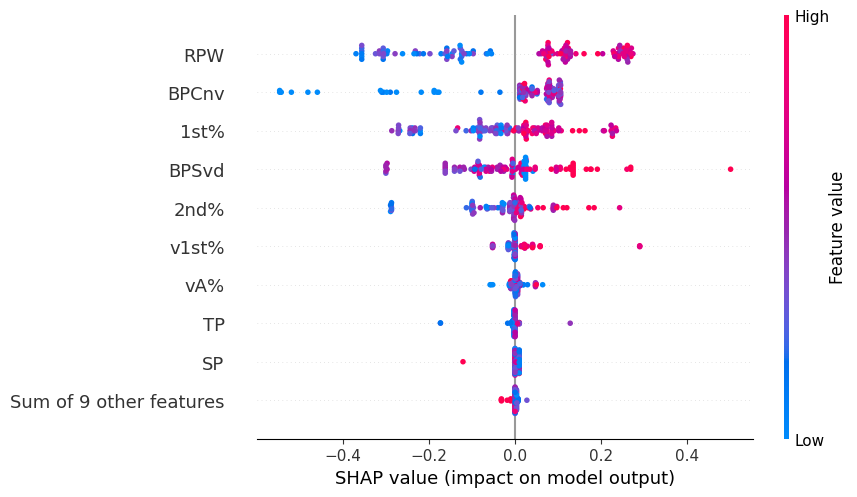

In [13]:
# Crear el explainer con el modelo y los datos de entrenamiento
explainer = shap.Explainer(dt_model, X_train)

# Calcular los valores SHAP con chequeo desactivado
shap_values = explainer(X_test, check_additivity=False)

# Extraer los valores SHAP de la clase 1 (victoria)
if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )
else:
    shap_values_class1 = shap_values

# Visualización de importancia global
shap.plots.bar(shap_values_class1)
shap.plots.beeswarm(shap_values_class1)

1. QUE VARIABLES PESAN MAS
La importancia promedio de cada variable en el conjunto de test. 
Es decir, cuánto cambia en promedio la predicción cuando se altera esa variable.
A partir de v1st% es baja

beeswarm aporta contexto al comportamiento partido a partido, mientras que bar resume la media global.

2. COMO LO HACEN
Cómo cada valor concreto de cada variable (en cada partido) influye en la predicción 
hacia victoria (SHAP > 0) o derrota (SHAP < 0).
Para cada variable (por fila), muestra:

Muchos puntos individuales (uno por partido).

El color del punto representa el valor de esa variable en ese partido:

Azul → valor bajo.

Rojo → valor alto.

La posición horizontal del punto (SHAP value) indica cuánto ese valor concreto empuja la predicción:

Hacia la derecha (SHAP > 0) → empuja a victoria.

Hacia la izquierda (SHAP < 0) → empuja a derrota.


In [14]:
# División entrenamiento/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar modelo Random Forest
rf_model = RandomForestClassifier(n_estimators=100, max_depth=10, random_state=42)
rf_model.fit(X_train, y_train)

# Evaluación del modelo
rf_y_pred = rf_model.predict(X_test)
rf_report = classification_report(y_test, rf_y_pred)
print("=== Evaluación Random Forest ===")
print(rf_report)

# Importancia de variables
rf_importances = pd.Series(rf_model.feature_importances_, index=X.columns).sort_values(ascending=False)
print("\n=== Importancia de Variables ===")
print(rf_importances)

=== Evaluación Random Forest ===
              precision    recall  f1-score   support

           0       0.91      0.76      0.83        51
           1       0.85      0.94      0.89        71

    accuracy                           0.87       122
   macro avg       0.88      0.85      0.86       122
weighted avg       0.87      0.87      0.87       122


=== Importancia de Variables ===
RPW      0.192866
BPCnv    0.125033
1st%     0.122846
2nd%     0.109805
v1st%    0.099633
v2nd%    0.066592
BPSvd    0.048209
DF%      0.028062
vA       0.024702
vA%      0.024442
A%       0.022955
TP       0.022947
1SP      0.022268
SP       0.020300
1stIn    0.019843
Aces     0.018028
2SP      0.015872
DFs      0.015598
dtype: float64


precision
De todas las veces que el modelo predijo esa clase, ¿cuántas veces acertó?

recall (sensibilidad)
De todas las veces que realmente ocurrió esa clase, ¿cuántas veces la predijo bien?

f1-score
Media armónica entre precisión y recall. Resume ambos en un único valor.
Un f1-score cercano a 1 significa un buen equilibrio entre aciertos y cobertura.

accuracy
Porcentaje total de aciertos del modelo.

macro avg
Media no ponderada entre las métricas de todas las clases (0 y 1). Trata por igual ambas clases.

weighted avg
Media ponderada por el número de ejemplos (support). Clases con más ejemplos pesan más.

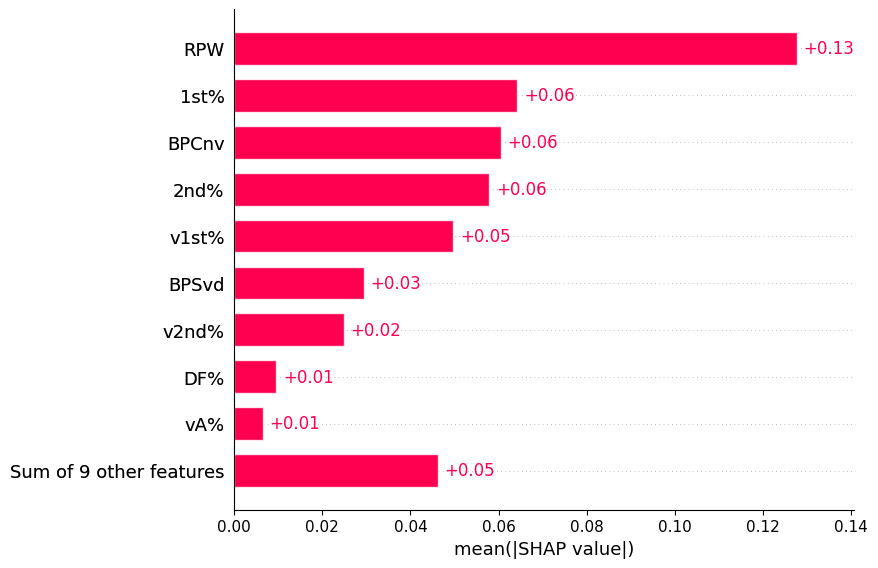

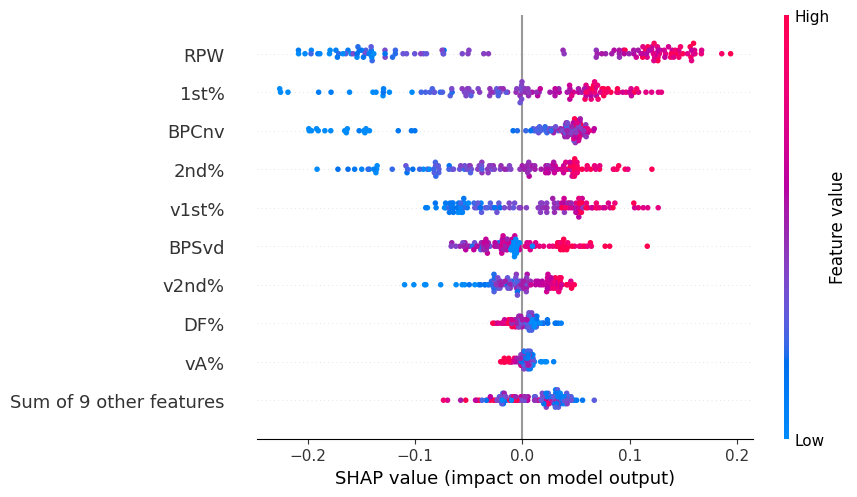

In [15]:
# 1. Crear el explainer con el modelo y X_train
explainer = shap.Explainer(rf_model, X_train)

# 2. Calcular valores SHAP (chequeo desactivado por estabilidad numérica)
shap_values = explainer(X_test, check_additivity=False)

# 3. Extraer valores SHAP de la clase 1 (victoria)
# Esto aplica solo si el output es multi-dimensional
if len(shap_values.values.shape) == 3:
    shap_values_class1 = shap.Explanation(
        values=shap_values.values[:, :, 1],
        base_values=shap_values.base_values[:, 1],
        data=shap_values.data,
        feature_names=shap_values.feature_names
    )
else:
    shap_values_class1 = shap_values  # fallback si es 2D

# 4. Visualización
shap.plots.bar(shap_values_class1)
shap.plots.beeswarm(shap_values_class1)

In [16]:
# Calcular la importancia por permutación en el conjunto de test
result = permutation_importance(
    rf_model,      # tu modelo entrenado
    X_test,        # conjunto de datos de test
    y_test,        # etiquetas verdaderas
    n_repeats=10,  # número de permutaciones (más alto = más preciso)
    random_state=42,
    scoring='accuracy'  # puedes cambiar a 'f1', 'recall', etc.
)

# Crear DataFrame ordenado
perm_importance_df = pd.DataFrame({
    'Variable': X_test.columns,
    'Importancia media': result.importances_mean,
    'Desviación estándar': result.importances_std
}).sort_values(by='Importancia media', ascending=False)

# Mostrar resultados
print("=== Importancia de Variables por Permutación ===")
print(perm_importance_df)

=== Importancia de Variables por Permutación ===
   Variable  Importancia media  Desviación estándar
6       RPW           0.050000             0.031201
3      1st%           0.024590             0.016798
4      2nd%           0.021311             0.009127
10    BPCnv           0.011475             0.012804
5     BPSvd           0.004918             0.011119
7       vA%          -0.000820             0.006809
16      2SP          -0.000820             0.008558
17       vA          -0.001639             0.007146
8     v1st%          -0.001639             0.018255
0        A%          -0.003279             0.008359
12     Aces          -0.003279             0.006557
9     v2nd%          -0.005738             0.006402
13      DFs          -0.006557             0.008031
15      1SP          -0.007377             0.005738
1       DF%          -0.009836             0.008828
2     1stIn          -0.013115             0.005437
11       TP          -0.016393             0.008979
14       SP    

=== Clasification Report ===
              precision    recall  f1-score   support

           0       0.95      0.82      0.88        51
           1       0.88      0.97      0.93        71

    accuracy                           0.91       122
   macro avg       0.92      0.90      0.91       122
weighted avg       0.91      0.91      0.91       122


=== Importancia de Variables ===
RPW      0.363148
2nd%     0.085519
1st%     0.077128
BPSvd    0.062912
BPCnv    0.060202
v1st%    0.048355
Aces     0.036303
DF%      0.034938
vA       0.033617
A%       0.029679
1SP      0.027971
SP       0.026084
1stIn    0.025339
TP       0.020751
v2nd%    0.019790
DFs      0.016339
2SP      0.016060
vA%      0.015865
dtype: float32


c:\Users\Usuario\AppData\Local\Programs\Python\Python311\Lib\site-packages\xgboost\training.py:183: UserWarning: [19:18:00] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


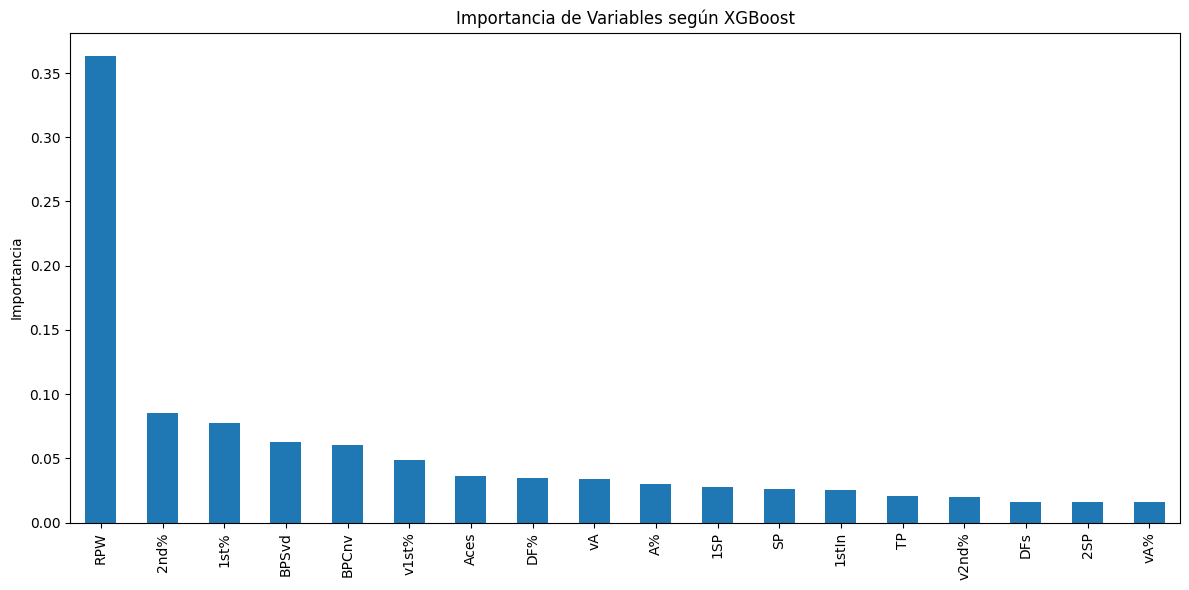

In [17]:
# División train/test
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# === 2. Entrenar modelo XGBoost ===
xgb_model = xgb.XGBClassifier(
    n_estimators=100,
    max_depth=5,
    learning_rate=0.1,
    use_label_encoder=False,
    eval_metric='logloss',
    random_state=42
)

xgb_model.fit(X_train, y_train)

# === 3. Evaluación del modelo ===
y_pred = xgb_model.predict(X_test)
print("=== Clasification Report ===")
print(classification_report(y_test, y_pred))

# === 4. Importancia de variables ===
importances = pd.Series(xgb_model.feature_importances_, index=X.columns).sort_values(ascending=False)

print("\n=== Importancia de Variables ===")
print(importances)

# Opcional: gráfico de barras
importances.plot(kind="bar", figsize=(12, 6), title="Importancia de Variables según XGBoost")
plt.ylabel("Importancia")
plt.tight_layout()
plt.show()

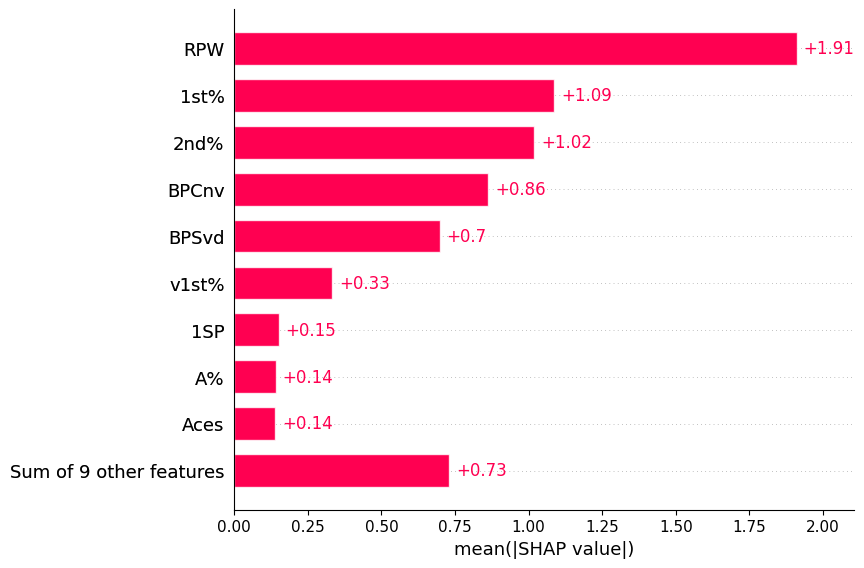

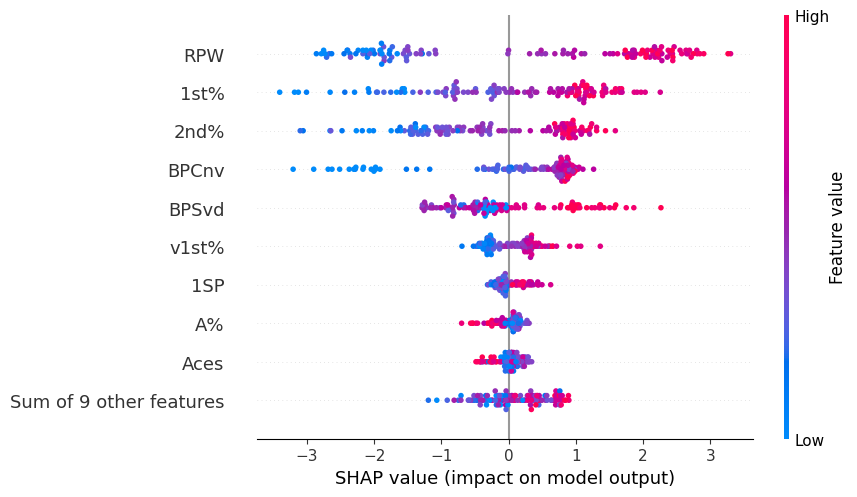

In [18]:
# === 1. Crear el explainer para XGBoost ===
explainer = shap.Explainer(xgb_model, X_train)

# === 2. Calcular valores SHAP para el conjunto de test ===
shap_values = explainer(X_test)

# === 3. Visualización de importancia global ===
# Barra: qué variables son más influyentes en promedio
shap.plots.bar(shap_values)

# Beeswarm: cómo influye cada variable y en qué dirección
shap.plots.beeswarm(shap_values)
